# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib
import skimage
import json
import wandb

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.Session(config=config)

#config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
#tf.keras.backend.set_session(tf.Session(config=config));

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
importlib.reload(modellib)
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5722695114846441675
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10670123426557118852
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2246019201570645819
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7331269837
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5486131776691423007
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


Using TensorFlow backend.


## Configurations

In [2]:
class IEConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "InteractiveElements"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # All classes
    CLASSES = ["Menu", "BackButton", "MoreOptions", "FloatingActionButton",
               "NavigationBarItem", "Button", "Checkbox", "RadioButton", "Switch"]
    # Number of classes (including background)
    NUM_CLASSES = 1 + len(CLASSES)  # background + 3 interactive element types
    
    DATASET_PATH = "dataset/"

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    #TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    #STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    #VALIDATION_STEPS = 5
    
    EPOCHS = 10 
    LAYERS = "head"
    
    INIT_WITH = "coco"  # imagenet, coco, or last
    
config = IEConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
CLASSES                        ['Menu', 'BackButton', 'MoreOptions', 'FloatingActionButton', 'NavigationBarItem', 'Button', 'Checkbox', 'RadioButton', 'Switch']
COMPUTE_BACKBONE_SHAPE         None
DATASET_PATH                   dataset/
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         10
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
INIT_WITH                      coco
LAYERS  

## Wandb

In [3]:
wandb.init(project="Test", entity="bmeyjohann", sync_tensorboard=True)

wandb.config = {
    "learning_rate": config.LEARNING_RATE,
    "learning_momentum": config.LEARNING_MOMENTUM,
    "epochs": config.EPOCHS,
    "batch_size": config.BATCH_SIZE,
    "image_min_dim": config.IMAGE_MIN_DIM,
    "image_max_dim": config.IMAGE_MAX_DIM,
    "init_with": config.INIT_WITH
}

wandb: Currently logged in as: bmeyjohann (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.3 available, but requires python3.6+, see http://wandb.me/library-eol-python35


## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=1):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [43]:
class IEDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_ie_subset(self, dataset_dir, subset):
        """Add images of train/test subfolder of the provided directory to dataset.
        dataset_dir: directory of images split into train/test folders.
        subset: 'train' or 'test' to choose between subfolders.
        """
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        self.load_ie(dataset_dir)

    def train_test_split(self, percentage):
        train_dataset = self
        test_dataset = IEDataset()
        test_dataset.add_classes()
        
        split_index = int(len(self.image_info) * percentage)
        test_dataset.image_info = self.image_info[split_index:]
        train_dataset.image_info = self.image_info[:split_index]
        
        print("Train contains ", len(train_dataset.image_info), "images.")
        print("Test contains ", len(test_dataset.image_info), "images.")
        
        return self, test_dataset
        
    def add_classes(self):
        for i in range(len(config.CLASSES)):
            self.add_class("InteractiveElements", i, config.CLASSES[i])

    def load_ie(self, dataset_dir):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        self.add_classes()
        
        # get size of one image since all should have the same size
        image_path = os.path.join(dataset_dir, "0.png")
        image = skimage.io.imread(image_path)
        height, width = image.shape[:2]
        
        file_index = 0
        # for every json file since there is one json file for each image
        while os.path.isfile(os.path.join(dataset_dir,str(file_index) + ".json")):
            with open(os.path.join(dataset_dir,str(file_index) + ".json")) as annotation_file:
                annotations = json.load(annotation_file)
                
                ids = []
                # for every interactive element in an image that shall be recognized
                for i in range(len(annotations.values())):
                    ids.append(self.get_index_of_class(annotations[str(i)]["class"]))
                
                self.add_image(
                    "InteractiveElements",
                    image_id=file_index,
                    path=os.path.join(dataset_dir, str(file_index)),
                    width=width, height=height,
                    num_ids=ids)
                
            file_index = file_index + 1
            
        print("Loaded", file_index, " images.")
        
    def get_index_of_class(self, class_of_element):
        for i in range(len(config.CLASSES)):
            if class_of_element == config.CLASSES[i]:
                return i + 1
        raise ValueError("Could not find index of class " + class_of_element)

    def load_image(self, image_id):
        """Return image from image id.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        image = skimage.io.imread(image_path + ".png")
        return image

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "InteractiveElements":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        image_path = info["path"]
        num_of_masks = len(info["num_ids"])
        
        masks = np.zeros([info['height'], info['width'], num_of_masks], dtype=np.bool)
        
        for mask_index in range(num_of_masks):
            image = skimage.io.imread(image_path + "_" + str(mask_index) + ".png")
            # masks[:, :, mask_index:mask_index+1] = image[:, :, 0:1].astype(np.bool)
            masks[:, :, mask_index] = image[:, :].astype(np.bool)
            
        return np.invert(masks), np.array(info["num_ids"])

In [44]:
dataset = IEDataset()
dataset.load_ie(config.DATASET_PATH)

dataset_train, dataset_val = dataset.train_test_split(0.8)

dataset_train.prepare()
dataset_val.prepare()

Loaded 200  images.
Train contains  160 images.
Test contains  40 images.


In [45]:
# Training dataset
#dataset_train = IEDataset()
#dataset_train.load_ie_subset(config.DATASET_PATH, "train")
#dataset_train.prepare()

# Validation dataset
#dataset_val = IEDataset()
#dataset_val.load_ie_subset(config.DATASET_PATH, "val")
#dataset_val.prepare()

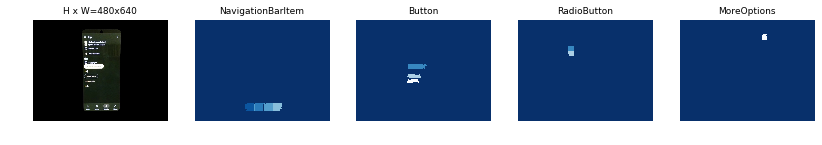

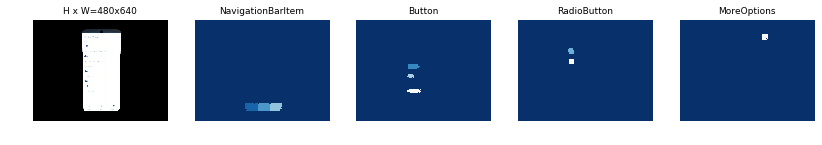

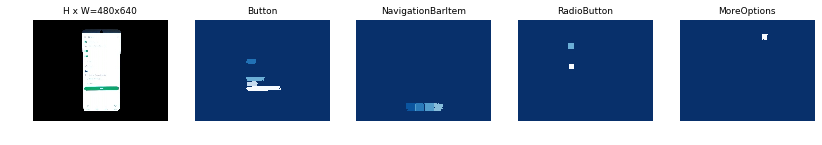

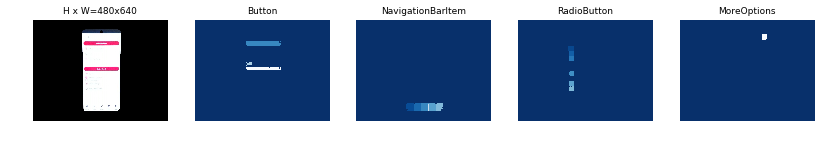

In [46]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [47]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [48]:
# Which weights to start with?

if config.INIT_WITH == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif config.INIT_WITH == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif config.INIT_WITH == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [49]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
config.EPOCHS=5
config.LAYERS='heads'

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=config.EPOCHS, 
            layers=config.LAYERS,
            custom_callbacks=[wandb.keras.WandbCallback()])

wandb: WARNING Keras version 2.0.8 is not fully supported. Required keras >= 2.4.0



Starting at epoch 0. LR=0.001

Checkpoint Path: /tf/logs/interactiveelements20220926T2309/mask_rcnn_interactiveelements_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 999/1000 [============================>.] - ETA: 0s - loss: 1.7177 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.9119 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.1597 - mrcnn_mask_loss: 0.3564

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
wandb: ERROR Can't save model, h5py returned error: can't pickle SwigPyObject objects


1000/1000 [==============================] - 307s - loss: 1.7174 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 0.9119 - mrcnn_class_loss: 0.2141 - mrcnn_bbox_loss: 0.1596 - mrcnn_mask_loss: 0.3563 - val_loss: 1.3391 - val_rpn_class_loss: 0.0343 - val_rpn_bbox_loss: 0.8530 - val_mrcnn_class_loss: 0.1199 - val_mrcnn_bbox_loss: 0.0731 - val_mrcnn_mask_loss: 0.2589
Epoch 2/5
1000/1000 [==============================] - 257s - loss: 1.1453 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.7112 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.2467 - val_loss: 1.1674 - val_rpn_class_loss: 0.0244 - val_rpn_bbox_loss: 0.7320 - val_mrcnn_class_loss: 0.1070 - val_mrcnn_bbox_loss: 0.0679 - val_mrcnn_mask_loss: 0.2362
Epoch 3/5
1000/1000 [==============================] - 258s - loss: 0.9402 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5674 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0483 - mrcnn_mask_loss: 0.2248 - val_loss: 1.0578 - val_rpn_class_loss: 0.0175 - val_rpn_bbox_loss

In [50]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
config.EPOCHS=5
config.LAYERS="all"

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=config.EPOCHS, 
            layers=config.LAYERS,
            hooks=[wandb.tensorflow.WandbHook(steps_per_log=100)])

TypeError: train() got an unexpected keyword argument 'hooks'

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [52]:
class InferenceConfig(IEConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /tf/logs/interactiveelements20220926T2309/mask_rcnn_interactiveelements_0004.h5
Re-starting from epoch 4


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (22,)                 min:    0.00000  max:  640.00000  float64
gt_class_id              shape: (16,)                 min:    2.00000  max:    9.00000  int64
gt_bbox                  shape: (16, 4)               min:  120.00000  max:  411.00000  int32
gt_mask                  shape: (512, 512, 16)        min:    0.00000  max:    1.00000  bool


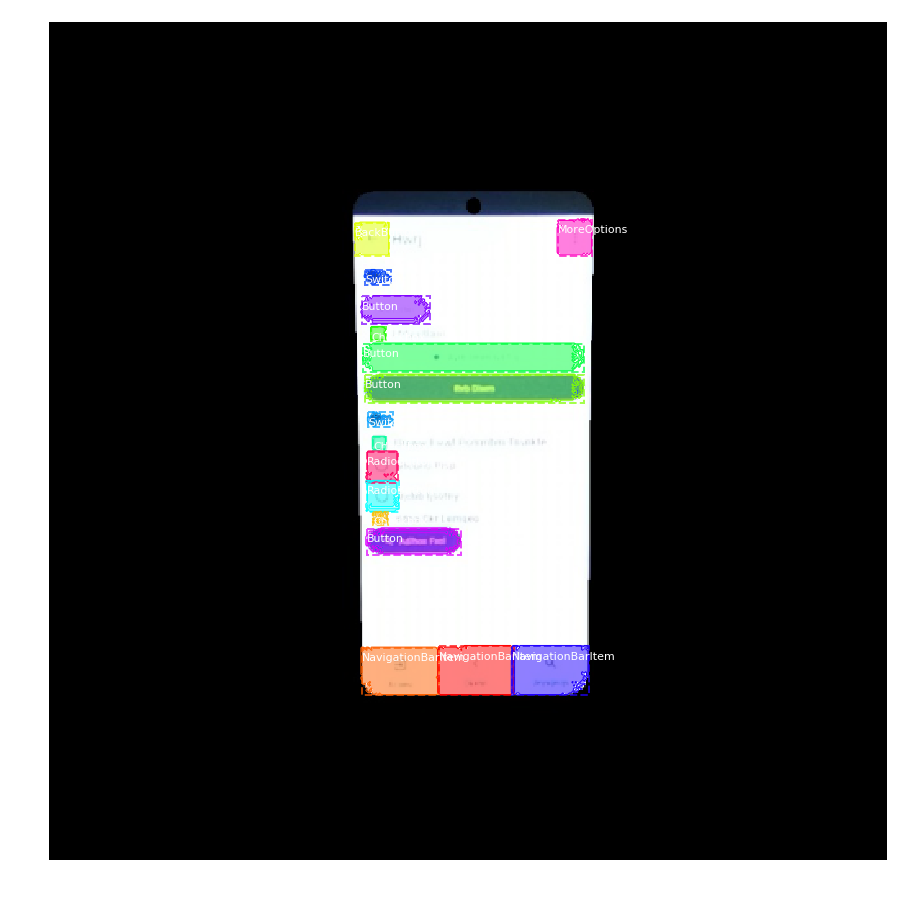

In [53]:
# Test on a random image
image_id = 2 # random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


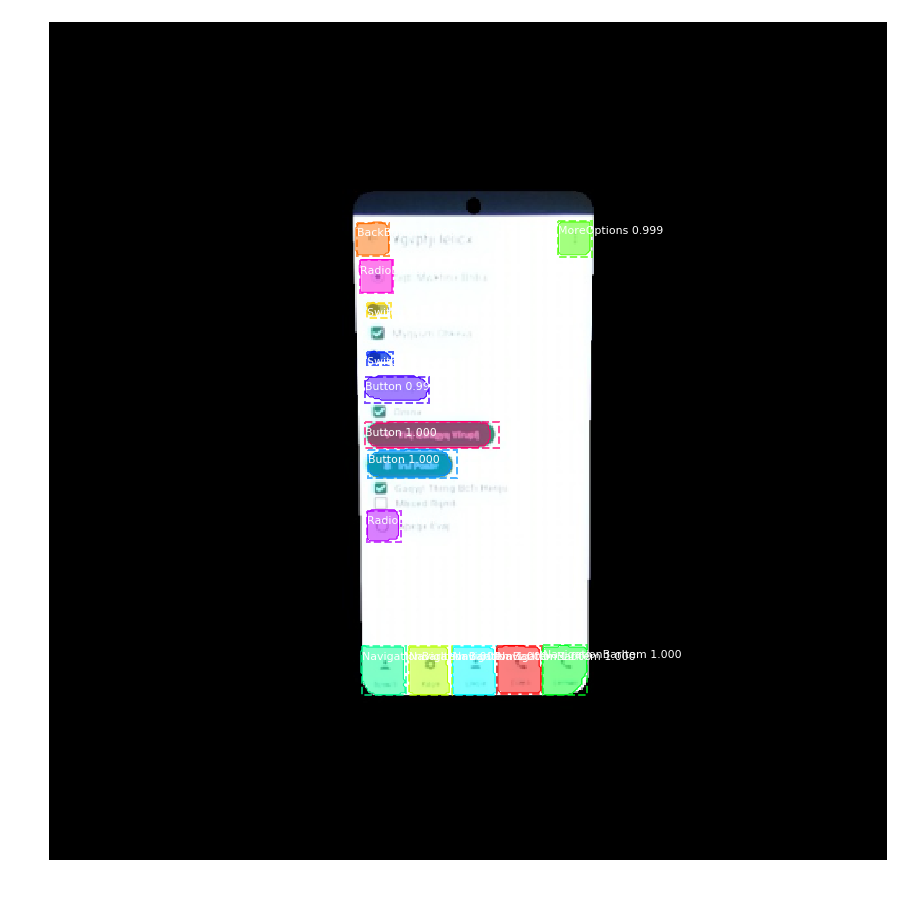

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


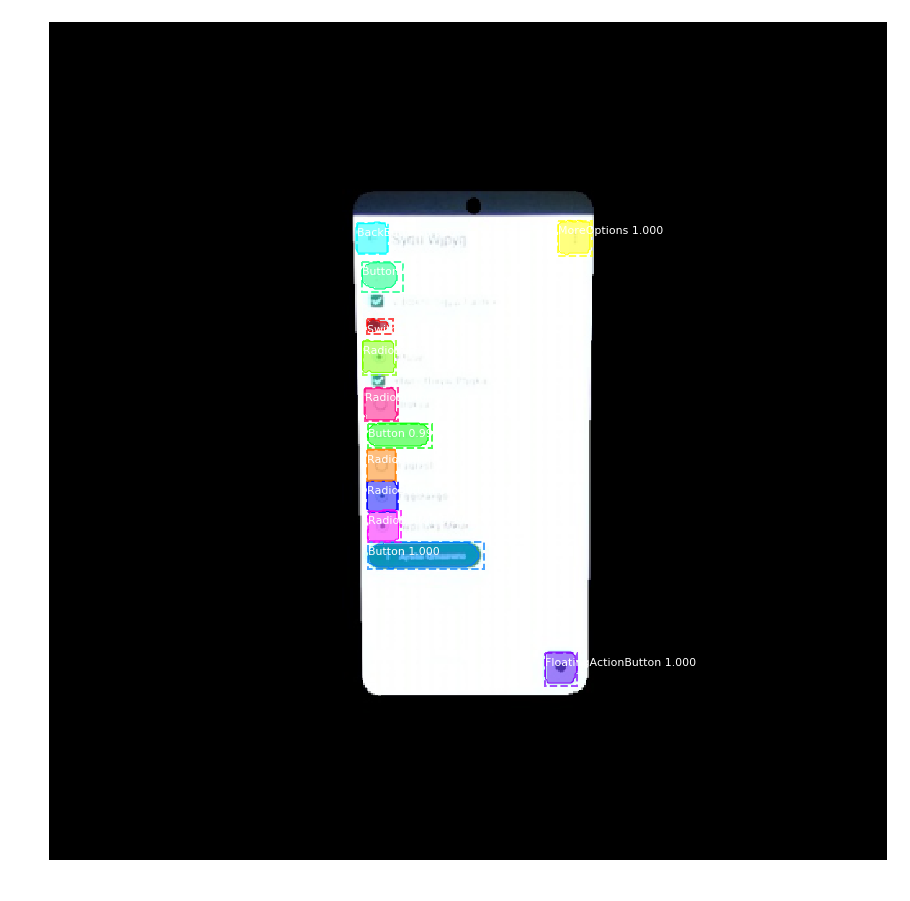

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


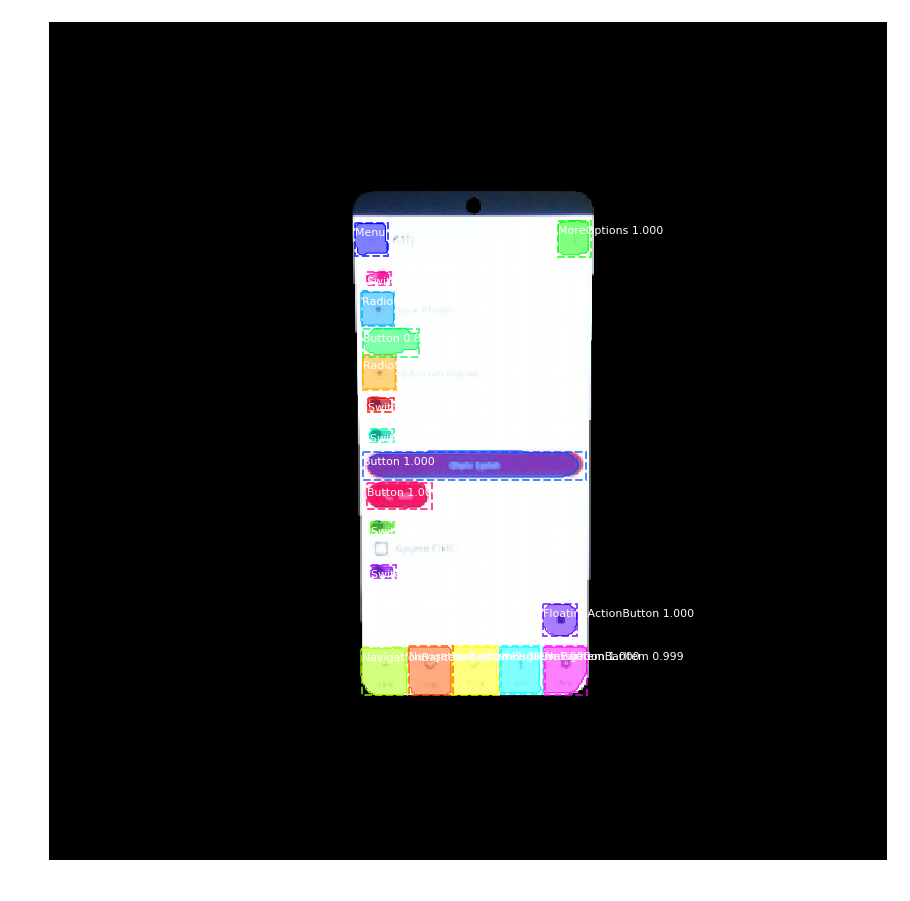

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


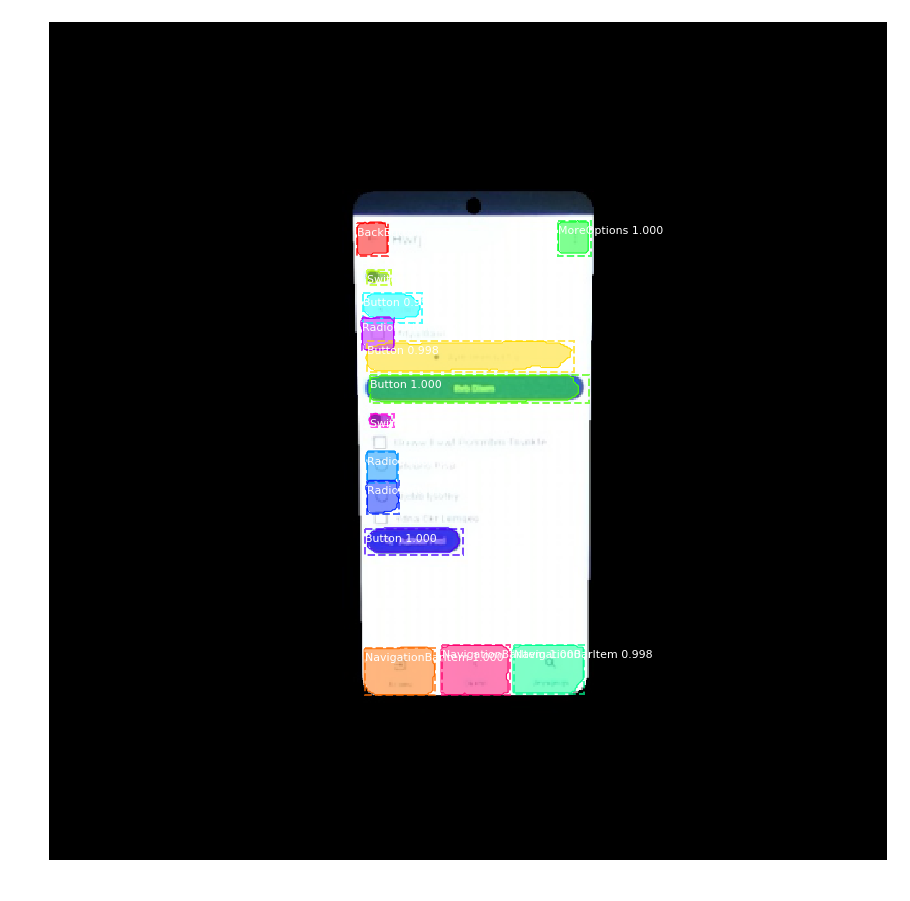

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32


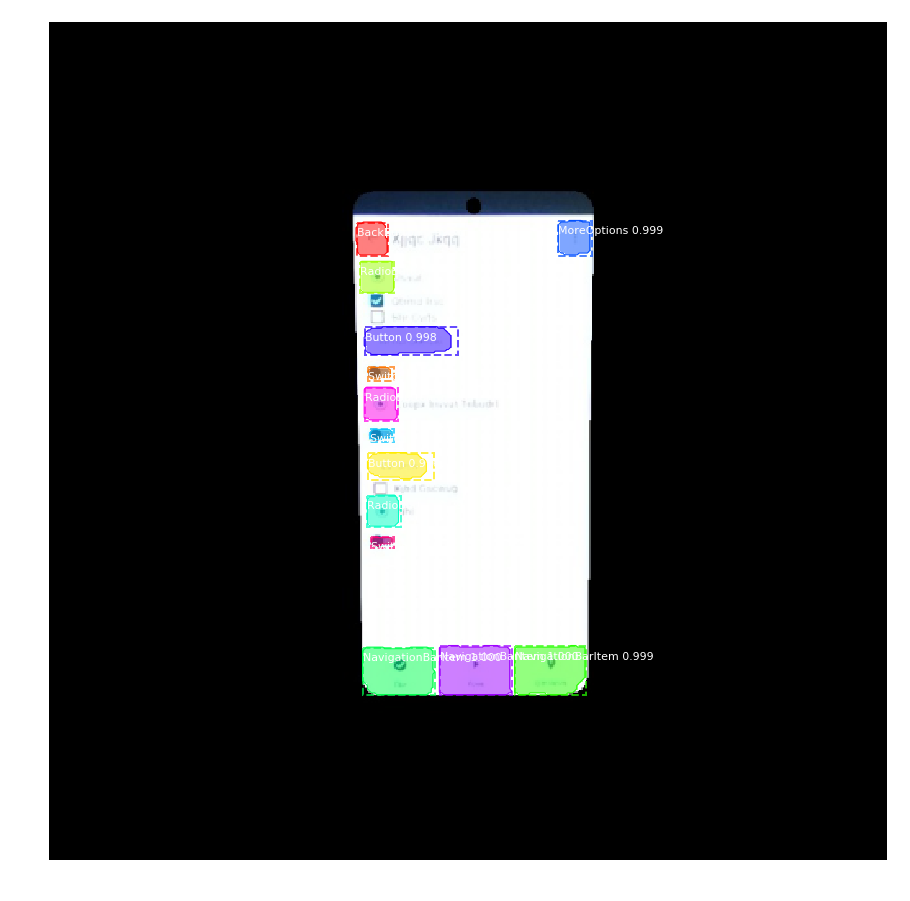

In [56]:
for i in (1,2,3,4, 7):
    image_id = random.choice(dataset_val.image_ids)
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=1)

    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(16, 16))

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

In [51]:
wandb.finish()

val_rpn_class_loss,0.02421
loss,0.75716
best_epoch,3
global_step,4
rpn_class_loss,0.01541
val_mrcnn_class_loss,0.08002
best_val_loss,0.94824
val_mrcnn_mask_loss,0.21759
mrcnn_class_loss,0.06325
mrcnn_mask_loss,0.20978
rpn_bbox_loss,0.43422


val_rpn_class_loss,██▄▄▁▂▁▄▂▄
loss,██▄▄▂▂▂▁▂▁
mrcnn_bbox_loss,██▃▃▂▁▂▁▁▁
rpn_class_loss,██▂▂▂▁▂▁▁▁
mrcnn_mask_loss,██▃▃▂▁▂▁▁▁
_runtime,▁▃▅▆█
val_mrcnn_mask_loss,██▅▅▃▁▃▂▁▂
mrcnn_class_loss,██▃▃▂▁▂▁▁▁
val_rpn_bbox_loss,██▅▅▃▁▃▁▁▁
rpn_bbox_loss,██▅▅▃▂▃▁▂▁
_step,▁▂▃▃▄▅▆▆▇█
